# Experimental Analysis of the Performance of gRPC vs REST vs REST(KA)
## David Walshe
## Scalable Microservices
## 03 May 2020

### Description:

This notebook analysis the performance of gRPC vs REST and REST with HTTP/1.1 keep alive. 

The dataset was generated in a LAN between two PC's. One machine was setup as a server, the other was setup as a request generating client. 

Measurements where acquired by genereting a timestamp using Node.js' *process.hrtime.bigint* timing utility. The timestamp is added to the outgoing request as a data field. 

On the server-side, the time stamp was extracted and added to the Response along with any required data, depending on the type of request (Empty, Single-Item, Multi-Item). The response is then sent to the client. 

The client on recieving the response, subtracted the response's *initial timestamp* from the current time. The difference is then treated as the approximiate **Round Trip Time**. 

The data was generate over 10 separate sessions between the client and server machine, for each protocal. 

During any particular session, 3000 requests are made to the server, 1000 for each metric (Empty Response, Single Item Response, Multi Item Response).

This results in 10000 records for each metric under test for each protocal

- gRPC -> 10000 records
- REST -> 10000 records
- REST(KA) -> 10000 records

---




## 0. Load Required Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

print(f"np: {np.__version__}")
print(f"pd: {pd.__version__}")
print(f"plt: {mpl.__version__}")
print(f"sns: {sns.__version__}")


np: 1.18.1
pd: 1.0.1
plt: 3.1.3
sns: 0.10.0


---




## 1. Load Datasets

There are three dataset present in this codebase, gRPC, REST and REST_KA (REST with Keep Alive turned on). 

In this section, the data will be loaded.

In [877]:
def loader(path: str) -> tuple:
    """
    Loads the datasets in a specific path (gRPC, rest, rest_ka).
    
    :param path: The path to the datasets.
    :returns: A tuple in the form (individual datasets, full dataset)
    """
    import os
    path = os.path.join("..", "data", path)
    dfs = []
    files = os.listdir(path)
    file_names = []
    for file in files:
        file = os.path.join(path, file)
        try:
            df = pd.read_csv(file).interpolate()
            dfs.append(df)
            file_names.append(file)
        except FileNotFoundError:
            pass
    
    full_df = pd.concat(dfs, ignore_index=True)
        
    return full_df, dfs, file_names

grpc, grpc_dfs, grpc_fnames = loader("gRPC")
rest, rest_dfs, rest_fnames = loader("rest")
rest_ka, rest_ka_dfs, rest_ka_fnames = loader("rest_ka")

The datasets are now loaded and ready to inspect

---



## 2. Inspecting the Raw Datasets

In this section, the datasets will be inspect to get a preliminary look a the data recorded.

### gRPC 

In [905]:
grpc.describe()  

,ERT,SIRT,MIRT
count,10000.000000,10000.000000,10000.000000
mean,73.593525,76.726546,92.275347
std,112.879125,114.028187,131.352112
min,4.467699,6.897401,9.262199
25%,23.281301,27.269824,36.491750
50%,40.778700,42.731350,49.287650
75%,68.065775,70.006749,84.735601
max,859.609600,944.531100,1057.147000


### REST

In [906]:
rest.describe()

,ERT,SIRT,MIRT
count,10000.000000,10000.000000,10000.000000
mean,421.195363,446.307216,465.339446
std,1602.076620,1641.642675,1643.948470
min,12.716500,15.354800,23.463899
25%,27.371726,41.825900,54.968299
50%,34.246201,49.651050,63.376200
75%,52.664775,69.156025,82.836576
max,15071.994200,15072.273899,15070.451100


### REST (With Keep Alive ON)

In [907]:
rest_ka.describe()

,ERT,SIRT,MIRT
count,10000.000000,10000.000000,10000.000000
mean,150.923317,169.901987,199.757885
std,367.602096,384.918561,432.633597
min,6.784200,12.697100,14.417200
25%,23.871699,35.954625,47.603250
50%,43.486600,54.449700,74.341800
75%,103.321325,120.608425,152.415450
max,9133.643501,7412.610800,9343.162300


From the above descriptions of the data, it can be seen that gRPC appears to have a slight edge over REST with keep-alive active and is significantly more performant then REST w/o keep-alive active.

---

## 3. Protocol Comparison

In this section, the data will be explored further by comparing it visually in a bar and box plot for each performance metric

- Empty Response.
- Single Item Response.
- Multiple Item Response.

The value used as a measurement unit is the RTT time that was recorded.


In [939]:
def show_RTT_for(metric: str, title: str):
    """
    Creates a bar plot comparing the requested metric from REST, REST(KA), gRPC.
    """
    names = ("REST", "REST(KA)", "gRPC")
    x_pos = np.arange(len(names))
    means = [rest[metric].mean(), rest_ka[metric].mean(), grpc[metric].mean()]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.grid(alpha=0.2)
    ax.bar(x_pos, means, align="center", alpha=0.5, color=("red", "green", "blue"))
    for x, y in zip(x_pos, means):
        ax.annotate(f"{y:.0f}", xy=(x-0.05, y-25))
    ax.set_xticks(y_pos)
    ax.set_xticklabels(names)
    for s in ["right", "top"]:
        ax.spines[s].set_visible(False)
    ax.set_title(title)


First, the **Empty Response** metric will be compared.

From the bar grpah below, it can be seen that gRPC is **twice** as fast as REST(KA) for this test data.

gRPC is also **5.6 times** faster then standard REST for this test data.

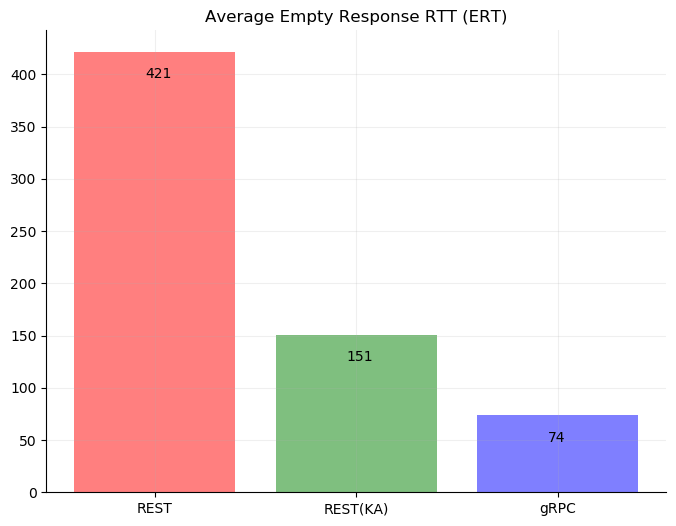

In [958]:
rest, rest_dfs, rest_fnames = loader("rest")
show_RTT_for(metric="ERT", title="Average Empty Response RTT (ERT)")

Second, the **Single Item Response** metric will be compared.

From the bar grpah below, it can be seen that gRPC is **2.2 times** as fast as REST(KA) and **5.7 times** as fast as REST.

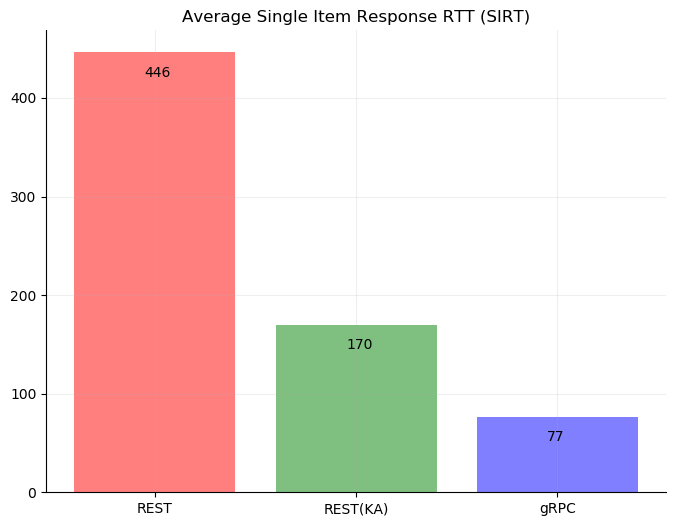

In [959]:
show_RTT_for(metric="SIRT", title="Average Single Item Response RTT (SIRT)")

Lastly, the **Multiple Item Response** metric will be compared.

From the bar grpah below, it can be seen that gRPC is **2.17 times** as fast as REST(KA) and **5.05 times** as fast as REST.

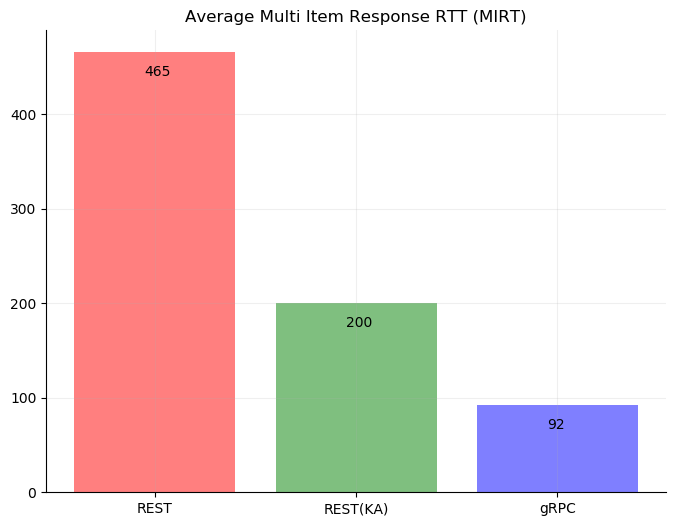

In [960]:
show_RTT_for(metric="MIRT", title="Average Multi Item Response RTT (MIRT)")

In the following cells, the general distribution of RTTs for each metric for each protocol can be observed via the use of box plots.

In [967]:
def show_box_plot_for(metric: str, label: str):
    # Create Boxplot for Empty Response RTT
    fig, ax = plt.subplots(figsize=(10, 6))
    labels = ("REST", "REST(KA)", "gRPC")
    
    data = []
    data.append(rest[metric])
    data.append(rest_ka[metric])
    data.append(grpc[metric])
    ax.boxplot(data, labels=labels, vert=False)
    ax.set_xlim(-100, 5000)
    ax.grid(alpha=0.2)
    ax.set_title(f"{label}")
    ax.set_xlabel("Milliseconds (ms)")

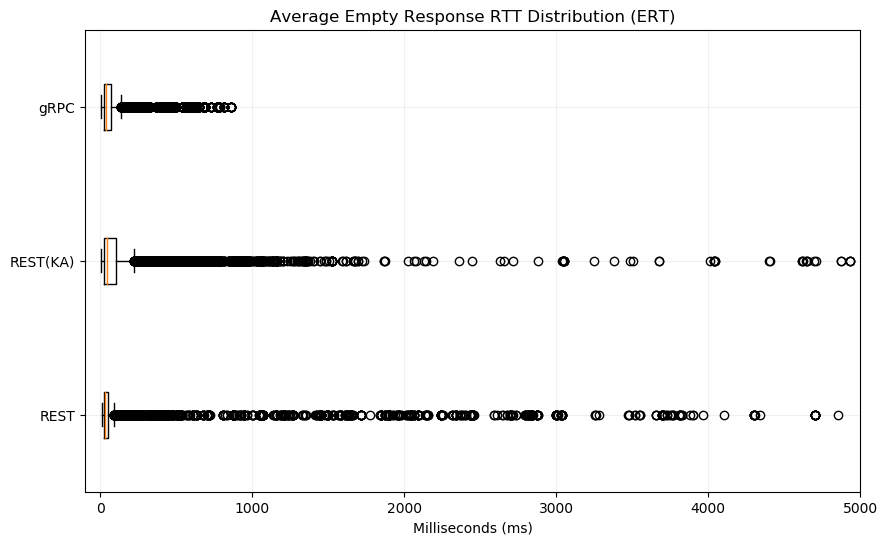

In [968]:
show_box_plot_for(metric="ERT", label="Average Empty Response RTT Distribution (ERT)")

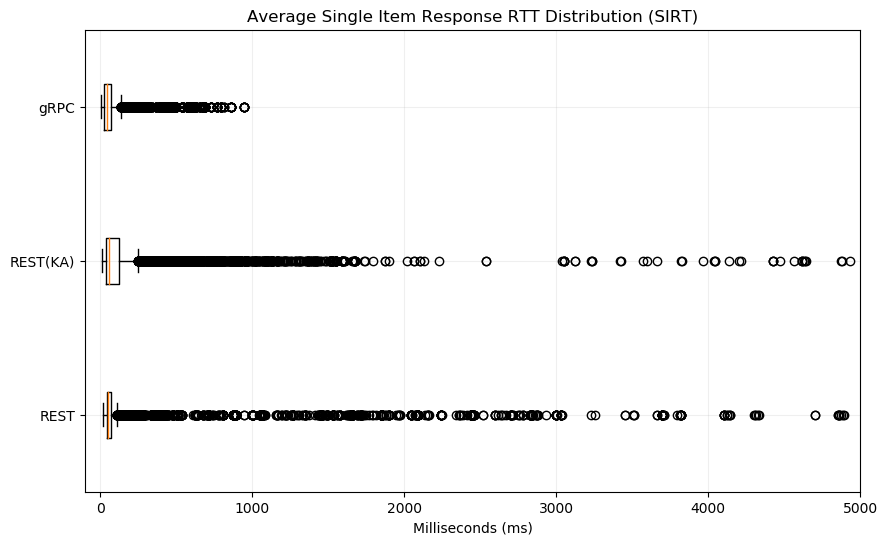

In [969]:
show_box_plot_for(metric="SIRT", label="Average Single Item Response RTT Distribution (SIRT)")

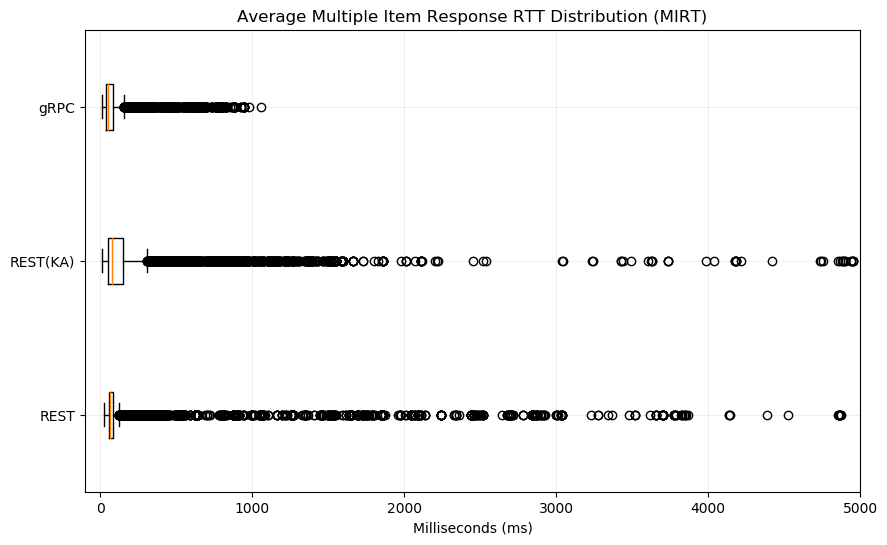

In [970]:
show_box_plot_for(metric="MIRT", label="Average Multiple Item Response RTT Distribution (MIRT)")

From the above box plots, it can be seen that gRPC is tightly clustered in the 0->1000ms range while REST and REST(KA) have considerably more outliers in the 1000+ range. 

**Note**: The range was reduced from the 27000 to 5000 on the X-axis to accomidate the bulk of the data. Their are points beyond 5000 for **REST** and **REST(KA)**.

---

## 4.Conclusion

From the above experiment it can be observed that gRPC is more performant in all three test metrics.

This experiment was performed over a local area network with both Server and Client machines on the same network. This experiment does not factor in internet latencies as the internet. 
